<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Информация-о-датасете" data-toc-modified-id="Информация-о-датасете-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Информация о датасете</a></span></li><li><span><a href="#Ресемплирование-данных-по-одному-часу" data-toc-modified-id="Ресемплирование-данных-по-одному-часу-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ресемплирование данных по одному часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li><li><span><a href="#Обучение-модели-RandomForestRegressor" data-toc-modified-id="Обучение-модели-RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение модели RandomForestRegressor</a></span></li><li><span><a href="#Обучение-модели-CatBoostRegressor" data-toc-modified-id="Обучение-модели-CatBoostRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Обучение модели CatBoostRegressor</a></span></li><li><span><a href="#Обучение-модели-DecisionTreeRegressor" data-toc-modified-id="Обучение-модели-DecisionTreeRegressor-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Обучение модели DecisionTreeRegressor</a></span></li><li><span><a href="#Обучение-модели-LGBMRegressor" data-toc-modified-id="Обучение-модели-LGBMRegressor-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Обучение модели LGBMRegressor</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

# Описание проекта
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Импорт библиотек и создание констант

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from time import time
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV


RANDOM_STATE = 12345
TEST_SIZE = 0.1

warnings.filterwarnings('ignore')

# Методы для работы 

## Загрузка данных

In [22]:
df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0]).sort_index()

### Информация о датасете

In [23]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

Всего в датасете 26496 строк. Пропусков не наблюдается, тип данных подобран корректно.

In [24]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Описание данных**

Количество заказов находится в столбце 'num_orders'.

### Ресемплирование данных по одному часу

In [25]:
df = df.resample('1H').sum()

## Анализ

In [26]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Визуализируем временной ряд, чтобы увидеть общие тренды и сезонности, а также проверим наличие аномалий.

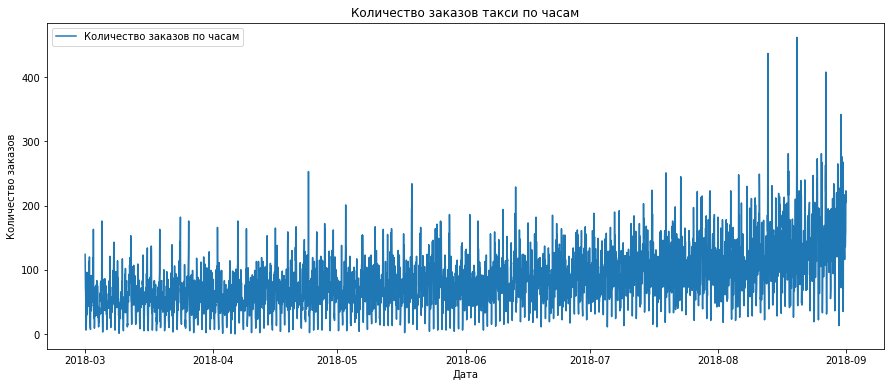

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['num_orders'], label='Количество заказов по часам')
plt.title('Количество заказов такси по часам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

На графике видно, что количество заказов такси по часам колеблется в течение дня и имеет некоторые тренды и возможно сезонность. Также заметны периоды с повышенным и пониженным спросом, что может соответствовать дням недели или определенным событиям.

**Проведем более детальный анализ данных, сосредоточив внимание на следующих аспектах:**
* Тренды: визуализация долгосрочных изменений в данных.
* Сезонность: изучение повторяющихся паттернов в данных.
* Остатки: анализ случайных компонентов данных, которые не объясняются трендами и сезонностью.


Для этого мы можем использовать декомпозицию временного ряда на тренд, сезонность и остатки. Это поможет нам лучше понять динамику данных и выявить возможные закономерности, которые могут быть полезны для прогнозирования.

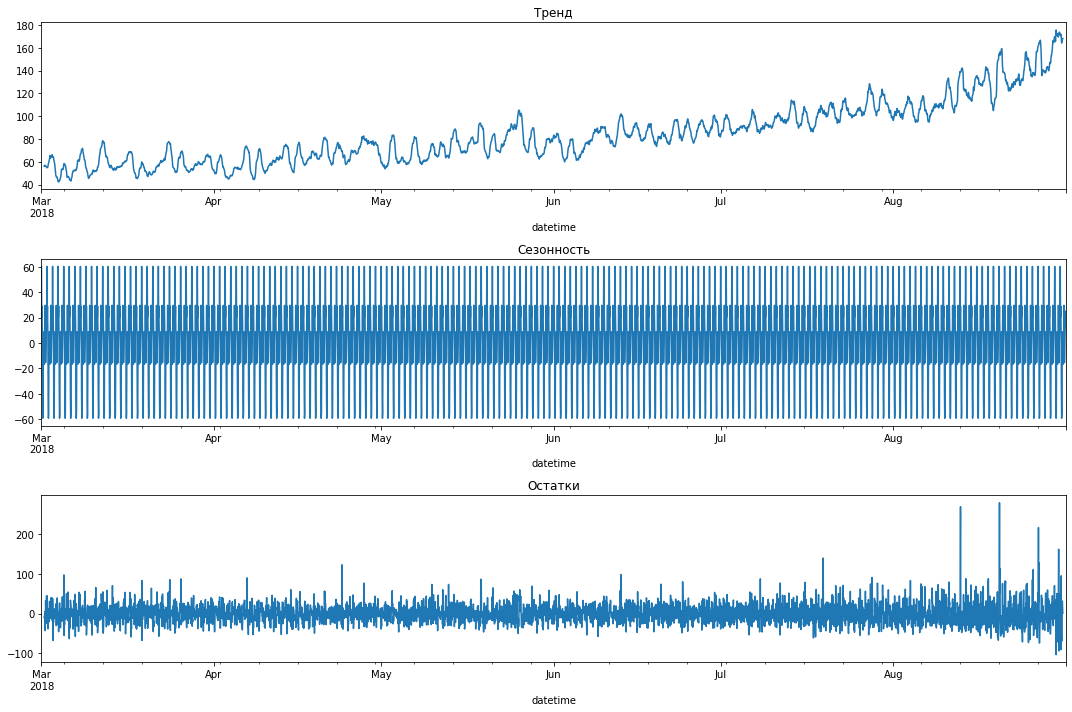

In [28]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), title='Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), title='Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), title='Остатки')

plt.tight_layout()
plt.show()

1. *Тренд:* Показывает общее долгосрочное направление изменения количества заказов такси. Мы видим, что общий тренд имеет восходящее направление, что может указывать на увеличение спроса на такси в течение рассматриваемого периода.
2. *Сезонность:* Отражает повторяющиеся паттерны в данных в течение короткого периода времени, например, в течение дня или недели. График сезонности демонстрирует четкие ежедневные колебания в количестве заказов, что может быть связано с ежедневными ритмами жизни людей.
3. *Остатки:* Представляют собой часть временного ряда, которая не может быть объяснена трендом и сезонностью. Эта компонента включает случайные и непредсказуемые флуктуации. На графике остатков видно, что большинство значений сгруппированы вокруг нуля, что указывает на хорошее разложение временного ряда на компоненты, хотя и остаются некоторые необъяснимые вариации.

**Проверим зависимость числа заказов от часа и дня недели**

In [29]:
df['rolling_mean'] = df.rolling(10).mean()

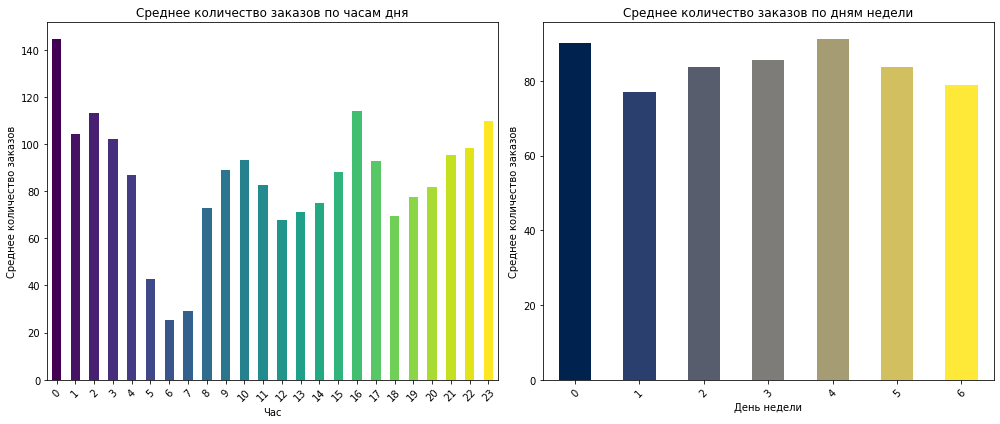

In [30]:
hourly_orders = df.groupby(df.index.hour).mean()
weekly_orders = df.groupby(df.index.dayofweek).mean()
days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

colors_hourly = plt.cm.viridis(np.linspace(0, 1, len(hourly_orders)))
colors_weekly = plt.cm.cividis(np.linspace(0, 1, len(weekly_orders)))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
hourly_orders['num_orders'].plot(kind='bar', color=colors_hourly, ax=plt.gca())
plt.title('Среднее количество заказов по часам дня')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.subplot(1, 2, 2)
weekly_orders['num_orders'].plot(kind='bar', color=colors_weekly, ax=plt.gca(), tick_label=days_of_week)
plt.title('Среднее количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Среднее количество заказов по часам дня:** Большая часть заказов приходится на вечерние и ночные часы, с пиком примерно в 00:00. Это может указывать на то, что спрос на такси возрастает в вечернее время, когда люди возвращаются домой с работы или развлечений. Также заметен повышенный спрос в утренние часы, начиная примерно с 6 утра, что соответствует началу рабочего дня.


**Среднее количество заказов по месяцам:** Существует некоторая сезонность в месячном распределении заказов. Однако, учитывая, что в наших данных представлены только месяцы с марта по август, мы видим, что спрос на такси увеличивается в теплые месяцы, с пиком в августе. Это может быть связано с увеличением числа туристов и общей активностью населения в теплое время года.

## Подготовка данных

**Создадим несколько признаков:**
* hour - час
* day - день
* dayofweek - день недели
* month - месяц

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(window=rolling_mean_size).mean()

    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop(columns='num_orders')
    target_train = train['num_orders']
    features_test = test.drop(columns='num_orders')
    target_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(
        model, features_train, target_train,
        scoring='neg_root_mean_squared_error',
        cv=TimeSeriesSplit(n_splits=5)
    ).mean()

    print(f'RSME = {rsme.round(2)} at lag = {max_lag}')
    return data

lags_list=[1,3,6,12,24]
data_temp =[]
df_new = df.copy()
for i in range(len(lags_list)):
    data_temp.append(make_features(df_new, lags_list[i], 24))
    display(data_temp[i].head())

RSME = 31.54 at lag = 1


,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0


RSME = 31.46 at lag = 3


,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0


RSME = 31.48 at lag = 6


,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN


RSME = 31.36 at lag = 12


,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 26.94 at lag = 24


,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение

Обучим несколько моделей:
* Модель RandomForestRegressor
* Модель CatBoostRegressor
* Модель DecisionTreeRegressor
* Модель LGBMRegressor

### Разделение данных на выборки

In [35]:
train, test = train_test_split(data_temp[4], shuffle=False, test_size=TEST_SIZE)
train = train.dropna()
    
features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']
print(features_train.shape,features_test.shape,target_train.shape,target_test.shape)

(3950, 29) (442, 29) (3950,) (442,)


### Обучение модели RandomForestRegressor

In [41]:
start_time = time.time()
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid_rf = {
    "max_depth": range(15, 16),
    "min_samples_leaf": range(2, 3)
}
gsearch_rf = GridSearchCV(model_rf, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch_rf.fit(features_train, target_train)
best_rf_rmse = -rf_model.best_score_
rf_time = time.time() - start_time

### Обучение модели CatBoostRegressor

In [42]:
start_time = time.time()
model_cb = CatBoostRegressor(random_state=12345, silent=True)
param_grid_cb = {
    "depth": [4, 6, 10],
}
gsearch_cb = GridSearchCV(model_cb, param_grid=param_grid_cb, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
cb_model = gsearch_cb.fit(features_train, target_train)
best_cb_rmse = -cb_model.best_score_
cb_time = time.time() - start_time

### Обучение модели DecisionTreeRegressor

In [43]:
start_time = time.time()
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid_dt = {
    "max_depth": range(15, 16),
    "min_samples_leaf": range(20, 30)
}
gsearch_dt = GridSearchCV(model_dt, param_grid=param_grid_dt, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch_dt.fit(features_train, target_train)
best_dt_rmse = -dt_model.best_score_
dt_time = time.time() - start_time

### Обучение модели LGBMRegressor

In [44]:
start_time = time.time()
model_lgbm = LGBMRegressor(random_state=12345, n_jobs=2)
param_grid_lgbm = {
    "max_depth": range(11, 12),
    "n_estimators": range(56, 57)
}
gsearch_lgbm = GridSearchCV(model_lgbm, param_grid=param_grid_lgbm, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
lgbm_model = gsearch_lgbm.fit(features_train, target_train)
best_lgbm_rmse = -lgbm_model.best_score_
lgbm_time = time.time() - start_time

### Сравнение моделей

In [45]:
results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "CatBoost", "LightGBM"],
    "Best RMSE": [best_dt_rmse, best_rf_rmse, best_cb_rmse, best_lgbm_rmse],
    "Training Time (s)": [dt_time, rf_time, cb_time, lgbm_time]
})

display(results)

,Model,Best RMSE,Training Time (s)
0,Decision Tree,28.776013,1.452089
1,Random Forest,25.316743,21.350889
2,CatBoost,24.127174,433.286592
3,LightGBM,24.876140,0.991853


В анализе полученных моделей машинного обучения, лучшей моделью считается та, которая демонстрирует наименьшее значение RMSE (Root Mean Square Error), указывая на более высокую точность предсказаний. Согласно полученным данным, модель CatBoost показывает наилучший результат с RMSE равным 24.127, что делает её наиболее точной среди рассмотренных моделей.

Однако, время обучения модели также играет важную роль, особенно в условиях, когда требуется быстрая обработка данных. С этой точки зрения, модель LightGBM выделяется как наиболее эффективная по времени, затрачивая всего около 0.992 секунды на обучение, при этом сохраняя сравнительно низкий RMSE 24.876.

Таким образом, если основным критерием является точность предсказаний, то CatBoost является предпочтительным выбором. В случае, когда необходимо учитывать и время обучения, LightGBM представляет собой более сбалансированный вариант, обеспечивая высокую точность при значительно меньших временных затратах.

## Тестирование

Протестируем модель на тестовых данных.

In [46]:
data_first_model = df.copy()
make_features(data_first_model, 12, 17)
data_first_model.dropna(inplace=True)

train, test = train_test_split(data_first_model,
                               shuffle=False,
                               test_size=0.1)
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

gb_model = stat.loc[11, 'Модель']
gb_model.fit(X_train, y_train)
predict_train = gb_model.predict(X_train)
predict_test = gb_model.predict(X_test)

train_rmse = mean_squared_error(y_train, predict_train)**0.5
test_rmse = mean_squared_error(y_test, predict_test)**0.5

print('Точность градиентного бустинга на обучающем наборе: {:.3f}'.format(train_rmse))
print('Точность градиентного бустинга на тестовом наборе: {:.3f}'.format(test_rmse))

RSME = 31.33 at lag = 12
Точность градиентного бустинга на обучающем наборе: 16.345
Точность градиентного бустинга на тестовом наборе: 42.450


Построим график сравнения фактического и прогнозируемого значения для модели.

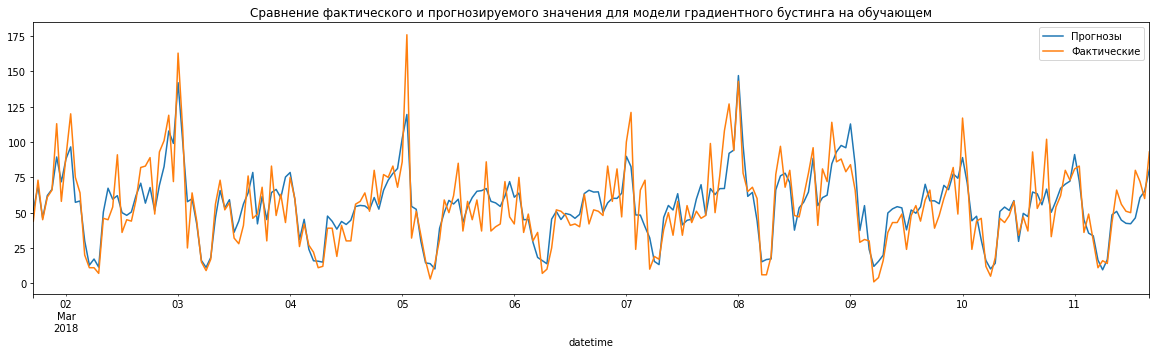

In [47]:
pd.DataFrame({'Прогнозы':predict_train,
             'Фактические':y_train})[:240].plot(figsize=(20,5))
plt.title('Сравнение фактического и прогнозируемого значения для модели градиентного бустинга на обучающем')
plt.show()